In [1]:
if "google.colab" in str(get_ipython()):
    from google.colab import drive
    import os
    drive.mount("/content/gdrive")
    os.chdir("/content/gdrive/My Drive/CS4243 Project/temp")
    !pwd
    %pip install -q ipywidgets
    %pip install -q -r requirements_colab.txt
else:
    %pip install -q -r requirements.txt

# may need to restart the kernel after installing new packages

Note: you may need to restart the kernel to use updated packages.


# Baseline (Convolutional Neural Network)

In [2]:
%reset

import torch
import torch.nn as nn

import time

import numpy as np
import matplotlib.pyplot as plt

In [6]:
from utils import load_tensor

train_unaug_x, train_unaug_y = load_tensor("unaug", "64")
test_x, test_y = load_tensor("test", "64")

train_unaug_x.size(), train_unaug_x.type(), train_unaug_y.size()

(torch.Size([5152, 3, 64, 64]), 'torch.FloatTensor', torch.Size([5152]))

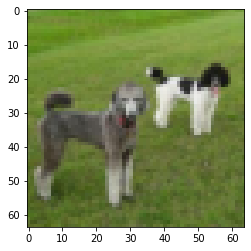

In [7]:
from utils import display_num_param, show, get_error

show(train_unaug_x[100])

In [8]:
def eval_on_test_set():

    test_size = test_x.size(0)
    running_error = 0
    num_batches = 0

    y_pred = []
    y_true = []

    for i in range(0,(test_size//bs)*bs, bs):

        minibatch_data =  test_x[i:i+bs]
        minibatch_label= test_y[i:i+bs]

        minibatch_data=minibatch_data.to(device)
        minibatch_label=minibatch_label.to(device)

        inputs = (minibatch_data - mean)/std

        scores = net(inputs) 

        error = get_error(scores, minibatch_label)

        labels = scores.argmax(dim=1)

        y_pred.extend(labels.tolist())
        y_true.extend(minibatch_label.tolist())
        

        running_error += error.item()

        num_batches += 1

    total_error = running_error/num_batches
    print( 'test error  = ', total_error*100 , 'percent')
    return total_error, y_pred, y_true


## Build CNN

A VGG-liked CNN Structure

In [9]:
class VGG_convnet(nn.Module):

    def __init__(self):

        super(VGG_convnet, self).__init__()

        # block 1:         3 x 64 x 64 --> 64 x 32 x 32        
        self.conv1a = nn.Conv2d(3,   64,  kernel_size=3, padding=1)
        self.conv1b = nn.Conv2d(64,  64,  kernel_size=3, padding=1)
        self.pool1  = nn.MaxPool2d(2,2)

        # block 2:         64 x 32 x 32 --> 128 x 16 x 16
        self.conv2a = nn.Conv2d(64,  128, kernel_size=3, padding=1)
        self.conv2b = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2  = nn.MaxPool2d(2,2)

        # block 3:         128 x 16 x 16 --> 256 x 8 x 8        
        self.conv3a = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3b = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3  = nn.MaxPool2d(2,2)
        
        #block 4:          256 x 8 x 8 --> 512 x 4 x 4
        self.conv4a = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.pool4  = nn.MaxPool2d(2,2)

        #block 5:          512 x 4 x 4 --> 512 x 2 x 2
        self.conv5a = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool5  = nn.MaxPool2d(2,2)

        # linear layers:   512 x 2 x 2 --> 2048 --> 4096 --> 4096 --> 10
        self.linear1 = nn.Linear(2048, 4096)
        self.linear2 = nn.Linear(4096, 4096)
        self.linear3 = nn.Linear(4096, 10)

        # dropout layer
        self.dropout = nn.Dropout(0.25)
    

    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv(x)


    # take out the conv layers for feature extraction
    def features_conv(self, x):
        x = self.conv1a(x)
        x = torch.relu(x)
        x = self.conv1b(x)
        x = torch.relu(x)
        x = self.pool1(x)
        x = self.dropout(x)

        x = self.conv2a(x)
        x = torch.relu(x)
        x = self.conv2b(x)
        x = torch.relu(x)
        x = self.pool2(x)
        x = self.dropout(x)

        x = self.conv3a(x)
        x = torch.relu(x)
        x = self.conv3b(x)
        x = torch.relu(x)
        x = self.pool3(x)

        x = self.conv4a(x)

        return x


    def forward(self, x, is_need_hook=False):

        x = self.features_conv(x)
        # remaining of blocks
        x = torch.relu(x)
        x = self.pool4(x)

        x = self.conv5a(x) 
        x = torch.relu(x)
        x = self.pool5(x)
        x = self.dropout(x)



        # Apply hook
        if is_need_hook:
            h = x.register_hook(self.activations_hook)


        x = x.contiguous()
        x = x.view(-1, 2048)
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = torch.relu(x)
        x = self.linear3(x) 
        
        return x


## A larger network

In [10]:
class VGG_convnet_large(nn.Module):

    def __init__(self):

        super(VGG_convnet_large, self).__init__()

        # block 1:         3 x 128 x 128 --> 64 x 64 x 64        
        self.conv1a = nn.Conv2d(3,   64,  kernel_size=3, padding=1)
        self.conv1b = nn.Conv2d(64,  64,  kernel_size=3, padding=1)
        self.pool1  = nn.MaxPool2d(2,2)

        # block 2:         64 x 64 x 64 --> 128 x 32 x 32
        self.conv2a = nn.Conv2d(64,  128, kernel_size=3, padding=1)
        self.conv2b = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2  = nn.MaxPool2d(2,2)

        # block 3:         128 x 32 x 32 --> 256 x 16 x 16        
        self.conv3a = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3b = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3  = nn.MaxPool2d(2,2)
        
        #block 4:          256 x 16 x 16 --> 512 x 8 x 8
        self.conv4a = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.pool4  = nn.MaxPool2d(2,2)

        #block 5:          512 x 8 x 8 --> 512 x 4 x 4
        self.conv5a = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool5  = nn.MaxPool2d(2,2)

        self.linear1 = nn.Linear(512*4*4, 4096)
        self.linear2 = nn.Linear(4096, 4096)
        self.linear3 = nn.Linear(4096, 10)

        # dropout layer
        self.dropout = nn.Dropout(0.25)


    def forward(self, x):

        x = self.conv1a(x)
        x = torch.relu(x)
        x = self.conv1b(x)
        x = torch.relu(x)
        x = self.pool1(x)
        # x = self.dropout(x)

        x = self.conv2a(x)
        x = torch.relu(x)
        x = self.conv2b(x)
        x = torch.relu(x)
        x = self.pool2(x)
        # x = self.dropout(x)

        x = self.conv3a(x)
        x = torch.relu(x)
        x = self.conv3b(x)
        x = torch.relu(x)
        x = self.pool3(x)

        x = self.conv4a(x)
        x = torch.relu(x)
        x = self.pool4(x)

        x = self.conv5a(x)
        x = torch.relu(x)
        x = self.pool5(x)
        # x = self.dropout(x)

        x = x.contiguous()
        x = x.view(-1, 512*4*4)
        x = self.linear1(x)
        x = torch.relu(x)
        # x = self.dropout(x)
        x = self.linear2(x)
        x = torch.relu(x)
        x = self.linear3(x) 
        
        return x


Try to implement a baseline Efficient Net (EfficientNet-B0) network

In [11]:
class EfficientNet(nn.Module):
    def __init__(self):
        super(EfficientNet, self).__init__()
        self.EfficientNetB4 = torchvision.models.efficientnet_b4(pretrained=False)
        self.EfficientNetB4 = self.EfficientNetB4.train()
        self.linear1 = nn.Linear(1000, 10)
    
    def forward(self, x):
        x = self.EfficientNetB4(x)
        x = nn.ReLU()(x)
        x = self.linear1(x)
        return x

## Create Net instance

In [12]:
# net = EfficientNet()
net = VGG_convnet()
print(net)
display_num_param(net)
# print(net.EfficientNetB4)

VGG_convnet(
  (conv1a): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2a): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3a): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3b): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4a): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5a): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool5)

In [13]:
device= torch.device("cuda")
#device= torch.device("cpu")
print(device)

cuda


In [14]:
mean = train_unaug_x.mean()
std = train_unaug_x.std()

mean, std

(tensor(0.4393), tensor(0.2521))

In [15]:
net = net.to(device)
mean = mean.to(device)
std = std.to(device)

## Define Early Stopping function

In [14]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoints/checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time test error improved.
            verbose (bool): If True, prints a message for each test error improvement. 
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
            path (str): Path for the checkpoint to be saved to.
            trace_func (function): trace print function.        
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.test_err_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        
    def __call__(self, test_err, model):

        score = -test_err

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(test_err, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            self.trace_func(f'Current Best Accuracy: {1 + self.best_score}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(test_err, model)
            self.counter = 0

    def save_checkpoint(self, test_err, model):
        if self.verbose:
            self.trace_func(f'Test error decreased ({self.test_err_min:.6f} --> {test_err:.6f}). Saving model...')
        torch.save(model.state_dict(), self.path)
        self.test_err_min = test_err

## Define Hyper-parameters

In [18]:
from cutmix.utils import CutMixCrossEntropyLoss

criterion = nn.CrossEntropyLoss()
# criterion = CutMixCrossEntropyLoss(True)
optimizer=torch.optim.AdamW(net.parameters(), lr=1e-4)
bs = 25
test_bs = 8
patience = 12
epochs = 100

## Training

In [16]:
start=time.time()

early_stopping = EarlyStopping(patience=patience, verbose=True)

train_losses = []
val_losses = []

for epoch in range(epochs):
    running_loss = 0
    running_error = 0
    num_batches = 0
    
    shuffled_indices=torch.randperm(train_unaug_x.size(0))
 
    for count in range(0, (train_unaug_x.size(0)//bs)*bs, bs):
    
        optimizer.zero_grad()
         
        indices=shuffled_indices[count:count+bs]
        minibatch_data = train_unaug_x[indices]
        minibatch_label = train_unaug_y[indices]

        minibatch_data = minibatch_data.to(device)
        minibatch_label = minibatch_label.to(device)
        
        inputs = (minibatch_data - mean)/std
        
        inputs.requires_grad_()

        scores = net(inputs) 

        loss = criterion(scores, minibatch_label) 
          
        loss.backward()

        optimizer.step()
    
        running_loss += loss.detach().item()
        
        error = get_error(scores.detach(), minibatch_label)
        running_error += error.item()
        
        num_batches += 1        
    
    total_loss = running_loss/num_batches
    total_error = running_error/num_batches
    elapsed = time.time()-start
    
    test_err = 0
    if epoch % 1 == 0:
        print('epoch=', epoch, '\t time=', elapsed, '\t loss=', total_loss , '\t error=', total_error*100 , 'percent')
        test_err = eval_on_test_set()[0]
        print(' ')
    
    
    early_stopping(test_err, net)
        
    if early_stopping.early_stop:
        print("Early stopping.....")
        break


# load the last checkpoint with the best model
net.load_state_dict(torch.load('checkpoints/checkpoint.pt'))

epoch= 0 	 time= 13.944353580474854 	 loss= 2.1365044574135714 	 error= 82.40776782475628 percent
test error  =  84.00000171227889 percent
 
Test error decreased (inf --> 0.840000). Saving model...
epoch= 1 	 time= 28.30366039276123 	 loss= 2.102777067897389 	 error= 82.34951542419138 percent
test error  =  78.90909232876517 percent
 
Test error decreased (0.840000 --> 0.789091). Saving model...
epoch= 2 	 time= 42.20223569869995 	 loss= 2.06496188536431 	 error= 79.68932152951805 percent
test error  =  77.45454636487094 percent
 
Test error decreased (0.789091 --> 0.774545). Saving model...
epoch= 3 	 time= 57.47347450256348 	 loss= 2.014055537946016 	 error= 75.24271945930222 percent
test error  =  76.72727378931913 percent
 
Test error decreased (0.774545 --> 0.767273). Saving model...
epoch= 4 	 time= 71.41422009468079 	 loss= 1.9820503864473509 	 error= 73.80582646837513 percent
test error  =  72.54545498978008 percent
 
Test error decreased (0.767273 --> 0.725455). Saving model..

<All keys matched successfully>

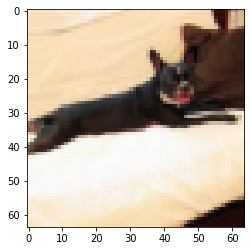

In [17]:
show(test_x[30])

## Show final result on test set

In [31]:
net.load_state_dict(torch.load('./checkpoints/checkpoint.pt'))

<All keys matched successfully>

In [32]:
error, y_pred, y_true = eval_on_test_set()

test error  =  62.54545531489632 percent


In [33]:
import importlib
import utils
importlib.reload(utils)

<module 'utils' from '/home/wei2912/Workspace/Chen-Yiyang/cs4243_project/utils.py'>

F1 Score : 0.31959380949617633
Precision: 0.37035490819965716
Recall   : 0.31612711258101334


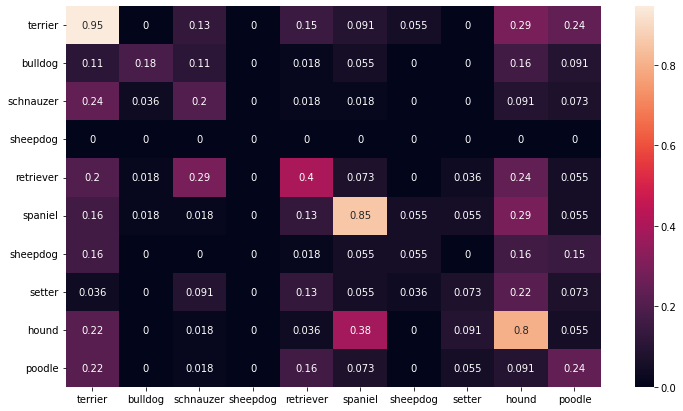

In [34]:
from utils import show_confusion_matrix, show_eval_metrics

show_confusion_matrix(y_pred, y_true)
show_eval_metrics(y_pred, y_true)

## Perform Grad-CAM on test instances

In [ ]:
from utils import CLASSES

def show_prob(pred_score):
    prob = torch.softmax(pred_score.cpu(), dim=1)
    p = prob.data.squeeze().numpy()

    ft=15
    label = CLASSES
    #p=p.data.squeeze().numpy()
    y_pos = np.arange(len(p))*1.2
    target=2
    width=0.9
    col= 'blue'
    #col='darkgreen'

    plt.rcdefaults()
    fig, ax = plt.subplots()

    # the plot
    ax.barh(y_pos, p, width , align='center', color=col)

    ax.set_xlim([0, 1.3])
    #ax.set_ylim([-0.8, len(p)*1.2-1+0.8])

    # y label
    ax.set_yticks(y_pos)
    ax.set_yticklabels(label, fontsize=ft)
    ax.invert_yaxis()  
    #ax.set_xlabel('Performance')
    #ax.set_title('How fast do you want to go today?')

    # x label
    ax.set_xticklabels([])
    ax.set_xticks([])
    #x_pos=np.array([0, 0.25 , 0.5 , 0.75 , 1])
    #ax.set_xticks(x_pos)
    #ax.set_xticklabels( [0, 0.25 , 0.5 , 0.75 , 1] , fontsize=15)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_linewidth(4)


    for i in range(len(p)):
        str_nb="{0:.2f}".format(p[i])
        ax.text( p[i] + 0.05 , y_pos[i] ,str_nb ,
                 horizontalalignment='left', verticalalignment='center',
                 transform=ax.transData, color= col,fontsize=ft)



    plt.show()

In [ ]:
from skimage.transform import resize
import cv2

def show_grad_cam(idx, num_channel=512):
    # display results
    img = test_x[idx]
    input = ((img.to(device) - mean) / std).unsqueeze(0)
    pred_score = net.forward(input, True)


    # get gradients over activation and generate heatmap
    pred_label = pred_score.argmax(dim=1)[0]
    pred_score[0,pred_label].backward()

    # pull the gradients out of the model
    gradients = net.get_activations_gradient()

    # pool the gradients across the channels
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

    # get the activations of the last convolutional layer
    activations = net.get_activations(input).detach()

    # weight the channels by corresponding gradients
    for i in range(num_channel):
        activations[:, i, :, :] *= pooled_gradients[i]
    
    # average the channels of the activations
    heatmap = torch.mean(activations, dim=1).squeeze().to('cpu')
    
    # relu on top of the heatmap
    # expression (2) in https://arxiv.org/pdf/1610.02391.pdf
    heatmap = np.maximum(heatmap, 0)
    
    # normalize the heatmap
    heatmap /= torch.max(heatmap)


    # scale the heatmap back to same size as input and generate superposed img
    img_size = img.size(1)
    heatmap_large = image_resized = resize(heatmap, (img_size, img_size),
                       anti_aliasing=True)
    #plt.matshow(heatmap_large)

    # generate colour map
    heatmap_large = np.uint8(255 * heatmap_large)
    heatmap_large = cv2.applyColorMap(heatmap_large, cv2.COLORMAP_JET)

    # obtain superimposed img
    heatmap_large = torch.Tensor(heatmap_large).permute(2,0,1).float() / 255
    superimposed_img = torch.Tensor(heatmap_large) * 0.3 + img
    superimposed_img = torch.clamp(superimposed_img, max=1)

    fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (20, 20))
    ax[0].imshow(img.permute(1,2,0))
    ax[0].set_title("Input img")
    ax[1].imshow(heatmap_large.permute(1,2,0))
    ax[1].set_title("Heatmap")
    ax[2].imshow(superimposed_img.permute(1,2,0))
    ax[2].set_title("Superimposed img")

    print("True label:", CLASSES[test_y[idx]])
    print("Pred label:", CLASSES[pred_label])

    show_prob(pred_score)


In [ ]:
idx = np.random.randint(test_x.size(0))
show_grad_cam(idx=idx, num_channel=512)